## Importing libraries

In [90]:
import pandas as pd
import string
import numpy as np
import json
import matplotlib.pyplot as plt
import json
import os
import cv2

%matplotlib inline


## Importing data, concating and ploting some analytics

In [3]:
# importing the data from the tree different files
with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/train_no_dup.json') as f:
    data1 = json.load(f)
train_df = pd.DataFrame(data1)

with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/test_no_dup.json') as f:
    data2 = json.load(f)
test_df = pd.DataFrame(data2)

with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/valid_no_dup.json') as f:
    data3 = json.load(f)
valid_df = pd.DataFrame(data3)

In [4]:
all_df = pd.concat([train_df,test_df,valid_df],ignore_index=True)


In [5]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21889 entries, 0 to 21888
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     21889 non-null  object
 1   views    21889 non-null  int64 
 2   items    21889 non-null  object
 3   image    21889 non-null  object
 4   likes    21889 non-null  int64 
 5   date     21889 non-null  object
 6   set_url  21889 non-null  object
 7   set_id   21889 non-null  object
 8   desc     21889 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.5+ MB


In [6]:
all_df.describe()

,views,likes
count,21889.000000,21889.000000
mean,3849.273608,319.877062
std,19699.915174,508.349814
min,4.000000,1.000000
25%,189.000000,29.000000
50%,715.000000,143.000000
75%,2267.000000,401.000000
max,521627.000000,12946.000000


<Axes: >

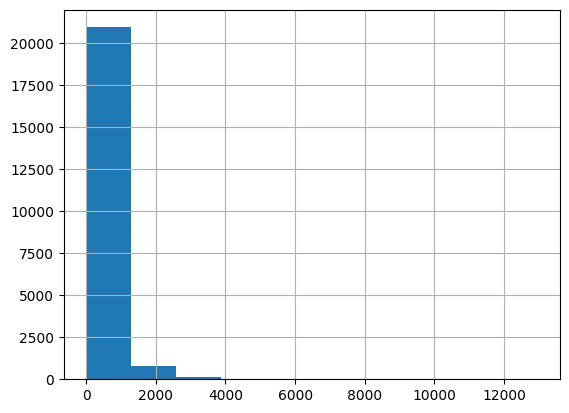

In [7]:
all_df['likes'].hist()


In [ ]:
all_df['likes_to_views_ratio'] = all_df['likes']/all_df['views']

In [8]:
all_df['log_likes'] = np.log(all_df.likes)

<Axes: >

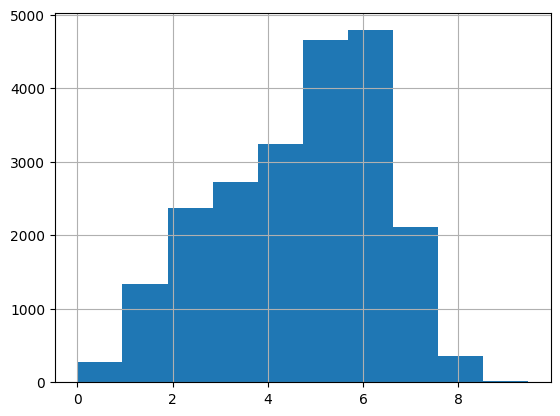

In [9]:
all_df.log_likes.hist()

## STEP 1:  Importing data creating items_ids, drop data we dont want etc.

In [ ]:
##STEP 1:
# We exrtact the categories of the items in the 'items' category. We ll use them later
# We can get the ratio of likes per views to get a better metric wheter the set is actually good or not
# We can then log it. First we the the ratio column and then we log it. Logging is the final step otherwise there is no differenece.
# Moreover we can cut the bottom %5 or some other ratio in order to get the outfits tha have been viewed a decemnt amount of times
#train_df['categories_list'] = train_df['items'].apply(lambda items_list: [item['categoryid'] for item in items_list])

#train_df['likes_to_views_ratio'] = train_df['likes']/train_df['views']

#train_df.drop(columns=(['items','image','set_url']),axis=1,inplace=True)

In [ ]:
##! OPTIONANL for testing
# #if we want to drop a percent of our dataset to crop the outliers
# lower_threshold = df['views'].quantile(0.05)
# upper_threshold = df['views'].quantile(0.95)
#np.log(train_df.likes/train_df.views).hist()
# df_filtered = train_df[(train_df['views'] >= lower_threshold) & (train_df['views'] <= upper_threshold)]


In [10]:
# importing the data from the tree different files
with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/train_no_dup.json') as f:
    data1 = json.load(f)
train_df = pd.DataFrame(data1)

with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/test_no_dup.json') as f:
    data2 = json.load(f)
test_df = pd.DataFrame(data2)

with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/valid_no_dup.json') as f:
    data3 = json.load(f)
valid_df = pd.DataFrame(data3)

In [11]:
# We use this function to summarize all of our first steps of preprocessing
def preprocessing_1 (df):
    #creating a list with the number of the items
    df['categories_list'] = df['items'].apply(lambda items_list: [item['categoryid'] for item in items_list])
    #creating the target vector. Or we can simply leave the 'likes' vector as the target vector
    df['likes_to_views_ratio'] = df['likes']/df['views']
    #drop the extra columns we dont want anymore 
    df.drop(columns=(['image','set_url','date']),axis=1,inplace=True)
    #lower the description to extract later some text
    df.desc.str.lower()
    # lower the name
    df.name.str.lower()
    # deleting the punctuation from both the columns
    df.desc = df.desc.str.lower().str.replace('[{}]'.format(string.punctuation), ' ', regex=True)
    df.name = df.name.str.lower().str.replace('[{}]'.format(string.punctuation), ' ', regex=True)
    return df

In [12]:
all_df = pd.concat([train_df,test_df,valid_df],ignore_index=True)
all_df = preprocessing_1(all_df)

In [15]:
# We create a new dictionary value for every item in the dictionary 
# with item_id which is the set_id concatenated with the index
# In this way every item will have its unique id number but will know in which set belongs
for index, row in all_df.iterrows():
    updated_items = []
    for item in row['items']:
        item['item_id'] = f"{row['set_id']}_{item['index']}"
        updated_items.append(item)
    all_df.at[index, 'items'] = updated_items

In [16]:
# Here we delete the values in the dictionaries of the items that we wont use anymore. We keep only index, categoryid, item_id
for index, row in all_df.iterrows():
    updated_items = []
    for item in row['items']:
        # Create a new dictionary with only desired columns
        new_item = {
            'index': item['index'],
            'categoryid': item['categoryid'],
            'likes': item['likes'],
            'item_id': f"{row['set_id']}_{item['index']}"
        }
        updated_items.append(new_item)
    all_df.at[index, 'items'] = updated_items

In [ ]:
# # ways to find common elements between two dataframes according to the set_id
# a = all_df.set_id
# b = all_df.set_id

# # First way with sets
# set1 = set(a)
# set2 = set(b)
# common_elements = list(set1 & set2)
# # Second way with intesect function
# def common_member(a, b):
#     return list(np.intersect1d(a, b))
# # Third way with list comprehension
# common_elements = list(filter(lambda elem: elem in a, b))

## EXTRACTING MENS OUTFITS (OPTIONAL FOR NOW)

In [9]:
#### STEP 1 : We try to find the outfits that may belong to mens fashion


# Our goal is to filter the outfits. Firstly we will try to extract the outfits tha may belonging to mens fashion
# In order to do it we locate the categories that refer to mens fashion according to the txt file.
# Then we try extracting inforamtion on the string columns (describe and name) 
# Initially we check for the outfits that may belong to men fashion
men_subcategories = [343,272,273,275,276,277,278,279,280,281,282,283,284,286,287,288,289,290,291,
                     292,293,294,295,296,297,298,299,300,301,302,303,304,305,342,4447,4454,4455,
                     4456,4457,4458,4459,4460,4461,4462,4463,4464,4465,4466,4467,4472,4474,4497,
                     4498,4520,4521,4522,4523,4524,4525,341]

In [ ]:
####### OPTIONAL: Here we check the index and the elements that are common betwwen the men_categories
# that are items for men fashion and the categories_list where there are the items in form of list of numbers
def common_member(a, b):
    return list(np.intersect1d(a, b))
# Third way with list comprehension

# Checking if there is 
men_fashion = []
count = 0
for i in range(0,len(all_df)):
    b = all_df['categories_list'][i]
    common_elements = common_member(men_subcategories, b)

    if not common_elements:
        continue
    else:    
        print("Index is: ",i, common_elements)
        count = count +1
        men_fashion.append(all_df['set_id'][i])

In [50]:
def has_common_elements(row):
    row_set = set(row['categories_list'])
    return bool(row_set.intersection(men_subcategories))

In [51]:
men_df_lists = all_df.copy()
men_df_NLP_name = all_df.copy()
men_df_NLP_desc = all_df.copy()


In [52]:
# in this list we keep the rows that have at least one common element with the list that has men items
men_df_lists = men_df_lists[men_df_lists.apply(has_common_elements, axis=1)]
# here we find any row that may have the words man, men, menswear in the name tag
men_df_NLP_name = men_df_NLP_name[men_df_NLP_name.name.str.contains(r'\b(men|man|menswear)\b', case=False)]
# same we try to find any rows that have description with men, man, menswear in them
men_df_NLP_desc = men_df_NLP_desc[men_df_NLP_desc.desc.str.contains(r'\b(men|man|menswear)\b', case=False)]

In [69]:
# we merge all the data frames
merged_df = pd.concat([men_df_lists, men_df_NLP_name, men_df_NLP_desc],ignore_index=True)
# we drop any dublicate rows that may have been arised
merged_df = merged_df.drop_duplicates(subset='set_id')

In [78]:
merged_df

,name,views,likes,set_id,desc,categories_list,likes_to_views_ratio
0,281 gt solivagant,851,118,191351163,a fashion look from february 2016 by dimibra f...,"[11, 25, 237, 46, 37, 64, 303]",0.138660
1,dylan o brien ii,893,31,132081114,dylan o brien dylanobrien teenwolf,"[40, 275, 283, 297, 300, 95, 316, 1967]",0.034714
2,a preppy life,8,7,214229253,a menswear look from january 2017 by luvadalov...,"[342, 4458, 295, 305, 4520, 4463, 303, 4472]",0.875000
3,sin título 63,169,20,106355827,a fashion look from december 2013 featuring ta...,"[104, 237, 318, 61, 106, 55, 297, 199]",0.118343
4,ignore unless tagged,295,38,213960031,a menswear look from december 2016 by lightyea...,"[275, 278, 4456, 297, 56]",0.128814
...,...,...,...,...,...,...,...
1786,plaid shorts,20,9,213101840,a menswear look from december 2016 by babiessw...,"[49, 102, 102, 102]",0.450000
1787,printed shorts,27,15,212931654,a menswear look from december 2016 by babiessw...,"[11, 2, 102, 4441]",0.555556
1794,plain boy,323,44,198451881,a menswear look from may 2016 featuring turtle...,"[11, 24, 49, 77]",0.136223
1797,little black dress and cardigan 18,807,544,207701263,a menswear look from september 2016 by ermanso...,"[43, 4, 36, 62, 18]",0.674102


In [90]:
# we want to find the dataframe without the rows of the mens fashino dataset we created above
condition = all_df['set_id'].isin(merged_df['set_id'])
all_df_no_men_outfits = all_df[~condition]
all_df_no_men_outfits

## STEP 2: Extracting Outfits based on our Forms

In [19]:
###### STEP 2: We try to find the outfits tha have the form we want without missing any other items


# Every number corresponds to a subcategory listed in a txt file in the dataset
# Then we map these subcategories to our categories
category_mapping = {
"Tops": [11, 15, 17,18,19,21,343,104,252,272,273,275,286,309,342,4454,4495,4496, 4497, 4498, 341 ],

"Bottoms": [7, 8, 9, 10, 27, 28, 29, 237, 238, 239, 240, 241, 251, 253, 254, 255, 278, 279, 280, 287, 288, 4452, 4458, 4459, 332],

"Accessories": [40, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 64, 65, 67, 105, 106, 107, 270, 299, 300, 301, 302, 303, 304, 305, 4447, 4463, 4466, 4467, 4470, 4472, 4523, 4524, 4525, 1967],

"Shoes": [41, 42, 43, 46, 47, 48, 49, 50, 261, 262, 263, 264, 265, 266, 267, 268, 291, 292, 293, 294, 295, 296, 297, 298, 4464, 4465, 4522],

"Outwear": [23, 24, 25, 26, 256, 276, 277, 289, 4455, 4457, 4456,236 ],

"Bags": [35, 36, 37, 38, 231, 258, 259, 290, 4461, 4462, 4474, 4520, 4521],

"Onepieces": [3, 4, 5, 6, 30, 75, 243, 244, 281, 4486, 4516, 1606, 1607]}

In [20]:
# Function to replace the numbers in the lists of "categories_list" column with the 
# corresponding Class name string according to the category_mapping dictionary
def replace_codes_with_names(codes):
    new_list = []
    for code in codes:
        for category, mappings in category_mapping.items():
            if code in mappings:
                new_list.append(category)
                break
        else:
            new_list.append("Other")  # If the code is not found in any mapping, tag it as "Other"
    return new_list

In [21]:
all_df['category_names'] = all_df['categories_list'].apply(replace_codes_with_names)


In [22]:
# Here we try to create a new value for every item in the dictionaries in "items" that has the name of the category
# We will use it later to extract proper outfits
def find_category_name(categoryid):
    for category_name, ids in category_mapping.items():
        if categoryid in ids:
            return category_name
    return "Other"
# Update the items column to include category_name
for idx, row in all_df.iterrows():
    for item in row['items']:
        item['category_name'] = find_category_name(item['categoryid'])
    all_df.at[idx, 'items'] = row['items']

In [24]:
form1 = {'Tops', 'Bottoms', 'Shoes', 'Bags', 'Accessories', 'Outwear'}
form2 = {'Onepieces', 'Shoes', 'Bags', 'Accessories', 'Outwear'}
form1_no_outerwear = form1 - {'Outwear'}
form2_no_outerwear = form2 - {'Outwear'}
# Function to filter rows based on forms WITH Outerwears
def filter_rows_WITH_outerwear(categories):
    # Exclude "Other" from the categories
    category_set = set(categories) - {'Other'}
    return category_set == form1 or category_set == form2
# Function to filter rows based on forms WITH NO Outerwears
def filter_rows_NO_outerwear(categories):
    # Exclude "Other" from the categories
    form1 
    category_set = set(categories) - {'Other','Outerwear'}
    return category_set == form1_no_outerwear or category_set == form2_no_outerwear

In [25]:
all_df_NO_Outerwear = all_df.copy()
all_df_WITH_Outerwear = all_df.copy()
all_df_WITH_Outerwear = all_df_WITH_Outerwear[all_df_WITH_Outerwear['category_names'].apply(filter_rows_WITH_outerwear)]
all_df_NO_Outerwear = all_df_NO_Outerwear[all_df_NO_Outerwear['category_names'].apply(filter_rows_NO_outerwear)]

In [28]:
# we delete the items in the "items" columns that have the "Other tag". We dont want the items tha belong to these categories.
# We drop items from the same category in an outfit. We keep the item with the most likes in case we have more than one item in same category in an outfit.
def preprocessing_2(df):
    
    for idx, row in df.iterrows():
        updated_items = [item for item in row['items'] if item['category_name'] != "Other"]
        df.at[idx, 'items'] = updated_items
         
    for idx, row in df.iterrows():
        # Dictionary to hold the item with the most likes for each category
        max_likes_items = {}
        
        # Iterate over items and keep track of the item with the maximum likes for each category
        for item in row['items']:
            category = item['category_name']
            likes = item['likes']
            
            # If the category is not seen before or the current item has more likes, update the dictionary
            if category not in max_likes_items or likes > max_likes_items[category]['likes']:
                max_likes_items[category] = item

        # Update the items column with the desired items
        df.at[idx, 'items'] = list(max_likes_items.values())   
        # We overwite the previous 'category_name' because we wont use it anymore
        df['category_names'] = df['items'].apply(lambda x: list({item['category_name'] for item in x}))
        # Creating a column with the length of the items in the list of dictionaries.
        df["length_of_category_name"] = df['items'].apply(len)       
    return df

In [30]:
all_df_WITH_Outerwear = preprocessing_2(all_df_WITH_Outerwear)
all_df_NO_Outerwear = preprocessing_2(all_df_NO_Outerwear)


In [33]:
# Some outfits here have 6 length and some other 5. This means that instead of Tops and Bottoms we have Onepiece. We seperate these two.
# We will encounter the same issue with every dataset.
# We end up here with 4 different dataframe. With Outerwear and Onepiece, With Outerwear and TOps/Bottoms, Without Outerwear and Onepiece, Without Outerwear and Tops/Bottoms
Outerwear_Onepiece = all_df_WITH_Outerwear[all_df_WITH_Outerwear['length_of_category_name'] == 5]
Outerwear_NO_Onepiece = all_df_WITH_Outerwear[all_df_WITH_Outerwear['length_of_category_name'] == 6]
NO_Outerwear_Onepiece = all_df_NO_Outerwear[all_df_NO_Outerwear['length_of_category_name'] == 4]
NO_Outerwear_NO_Onepiece = all_df_NO_Outerwear[all_df_NO_Outerwear['length_of_category_name'] == 5]

In [ ]:
######## OPTIONAL#################
# # We use this code if we want to create different folders with categories of the outfits and copy them there. Maybe it wont ne needed.
# import os
# import shutil
# import tqdm
# source_directory = "/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/all_images"
# destination_directory = "/home/thanos/Desktop/Sustainable_fashion/data/polyvore_for_recommendation_tool/NO_outwear_NO_onepiece"

# for idx, row in NO_Outerwear_NO_Onepiece.iterrows():
#     for item in row['items']:
#         # Extract the filename and category
#         filename = item['item_id'] + ".jpg"  # Assuming the images are in jpg format
#         category = item['category_name']
        
#         # Create a new directory for the category if it doesn't exist
#         category_directory = os.path.join(destination_directory, category)
#         # if not os.path.exists(category_directory):
#         #     os.makedirs(category_directory)
        
#         # Copy the image to the category directory
#         source_path = os.path.join(source_directory, filename)
#         destination_path = os.path.join(category_directory, filename)
#         print(source_path,destination_path)
#         shutil.copy(source_path, destination_path)
# count = 0
# for idx, row in Outerwear_NO_Onepiece.iterrows():
#     count=count +1
#     for item in row['items']:
#         print(item['item_id'],item['category_name'])
#     print(count)  




In [46]:
Outerwear_Onepiece.to_json ("Outfits_Outerwear_Onepiece.json", orient='records')
Outerwear_NO_Onepiece.to_json("Outfits_Outerwear_Tops_Bottoms.json", orient='records')
NO_Outerwear_Onepiece.to_json("Outfits_NO_Outerwear_Onepiece.json", orient='records')
NO_Outerwear_NO_Onepiece .to_json("Outfits_NO_Outerwear_Tops_Bottoms.json", orient='records')

## STEP 3 Creating dataframe with image paths

In [110]:
with open('/home/thanos/Desktop/Sustainable_fashion/repos/Recommendation_tool/Outfits_NO_Outerwear_Onepiece.json') as f:
    data1 = json.load(f)
image_paths_NO_Outerwear_Onepiece = pd.DataFrame(data1)

In [111]:
with open('/home/thanos/Desktop/Sustainable_fashion/repos/Recommendation_tool/Outfits_NO_Outerwear_Tops_Bottoms.json') as f:
    data1 = json.load(f)
image_paths_NO_Outerwear_NO_Onepiece = pd.DataFrame(data1)

In [112]:
with open('/home/thanos/Desktop/Sustainable_fashion/repos/Recommendation_tool/Outfits_Outerwear_Onepiece.json') as f:
    data1 = json.load(f)
image_paths_Outerwear_Onepiece = pd.DataFrame(data1)

In [113]:
with open('/home/thanos/Desktop/Sustainable_fashion/repos/Recommendation_tool/Outfits_Outerwear_Tops_Bottoms.json') as f:
    data1 = json.load(f)
image_paths_Outerwear_NO_Onepiece = pd.DataFrame(data1)

In [114]:
# We create a new data frame with columns the different categories and the set_id and likes from the previous dataframe
# Every row has an set or Outfit, the categories columns have the paths of the images corresponding to the category they 
# belong through the "items" of the previous dataset. Columns of set_id has the set id as it says and "likes" column has the corresponding number of likes we want to predict
def image_paths_to_columns(df):
# Your data path
    data_path = '/notebooks/all_images/'

    # Assuming df is your DataFrame containing 'likes', 'items', and 'set_id'
    df = df[["items","likes","set_id"]]
    # Create a new DataFrame to hold the paths
    columns = list(df.columns)

    df_image_paths = pd.DataFrame(columns=columns)

    # Iterate through each row in the original DataFrame
    for index, row in df.iterrows():
        new_row = {}
        items = row['items']  # Get the items
        
        # Iterate through each item in items
        for item in items:
            # Add the item's image path to the new row under the respective category column
            new_row[item['category_name']] = os.path.join(data_path, f"{item['item_id']}.jpg")  # or whichever your image format is
        
        # Add the set_id and likes to the new row
        new_row['set_id'] = row['set_id']
        new_row['likes'] = row['likes']
        
        # Append the new row to the new DataFrame
        df_image_paths = df_image_paths.append(new_row, ignore_index=True)

    # Ensure the 'set_id' and 'likes' columns are of integer type
    df_image_paths = df_image_paths.drop('items', axis=1)
    df_image_paths['set_id'] = df_image_paths['set_id'].astype(int)
    df_image_paths['likes'] = df_image_paths['likes'].astype(int)
    df_image_paths['log_likes'] = np.log(df_image_paths.likes)
    df_image_paths.drop(['likes','set_id'], axis=1, inplace=True)
    return df_image_paths

In [115]:
df_image_paths_NO_Outerwear_Onepiece = image_paths_to_columns(image_paths_NO_Outerwear_Onepiece)
df_image_paths_NO_Outerwear_NO_Onepiece = image_paths_to_columns(image_paths_NO_Outerwear_NO_Onepiece)
df_image_paths_Outerwear_Onepiece = image_paths_to_columns(image_paths_Outerwear_Onepiece)
df_image_paths_Outerwear_NO_Onepiece = image_paths_to_columns(image_paths_Outerwear_NO_Onepiece)

<ipython-input-114-bd88ca00fa1e>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_image_paths = df_image_paths.append(new_row, ignore_index=True)
<ipython-input-114-bd88ca00fa1e>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_image_paths = df_image_paths.append(new_row, ignore_index=True)
<ipython-input-114-bd88ca00fa1e>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_image_paths = df_image_paths.append(new_row, ignore_index=True)
<ipython-input-114-bd88ca00fa1e>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_image_paths = df_image_paths.append(new_row, ignore_index=True)
<ipython-input-114-bd88ca00fa1e>:30: FutureW

In [116]:
df_image_paths_NO_Outerwear_Onepiece

,Onepieces,Shoes,Bags,Accessories,log_likes
0,/notebooks/all_images/196794889_1.jpg,/notebooks/all_images/196794889_2.jpg,/notebooks/all_images/196794889_3.jpg,/notebooks/all_images/196794889_7.jpg,5.659482
1,/notebooks/all_images/194797482_1.jpg,/notebooks/all_images/194797482_2.jpg,/notebooks/all_images/194797482_3.jpg,/notebooks/all_images/194797482_4.jpg,2.397895
2,/notebooks/all_images/212745062_1.jpg,/notebooks/all_images/212745062_3.jpg,/notebooks/all_images/212745062_4.jpg,/notebooks/all_images/212745062_5.jpg,6.670766
3,/notebooks/all_images/216661833_1.jpg,/notebooks/all_images/216661833_2.jpg,/notebooks/all_images/216661833_3.jpg,/notebooks/all_images/216661833_4.jpg,3.465736
4,/notebooks/all_images/216601452_1.jpg,/notebooks/all_images/216601452_2.jpg,/notebooks/all_images/216601452_3.jpg,/notebooks/all_images/216601452_5.jpg,3.871201
...,...,...,...,...,...
1733,/notebooks/all_images/202775801_1.jpg,/notebooks/all_images/202775801_3.jpg,/notebooks/all_images/202775801_4.jpg,/notebooks/all_images/202775801_7.jpg,6.499787
1734,/notebooks/all_images/196185936_1.jpg,/notebooks/all_images/196185936_3.jpg,/notebooks/all_images/196185936_4.jpg,/notebooks/all_images/196185936_5.jpg,6.502790
1735,/notebooks/all_images/153286878_1.jpg,/notebooks/all_images/153286878_2.jpg,/notebooks/all_images/153286878_3.jpg,/notebooks/all_images/153286878_4.jpg,5.402677
1736,/notebooks/all_images/172329514_1.jpg,/notebooks/all_images/172329514_2.jpg,/notebooks/all_images/172329514_3.jpg,/notebooks/all_images/172329514_6.jpg,7.342779


In [ ]:
df_image_paths_NO_Outerwear_NO_Onepiece

In [ ]:
df_image_paths_Outerwear_Onepiece

In [ ]:
df_image_paths_Outerwear_NO_Onepiece

In [97]:
#### OPTIONAL FUNCTION ######
# We use this function to display the outfits with all their items together row by row.

def display_outfit(row_number,df_image_paths,categories_num):    
    #   Assuming you want to display images from the first row
    # Extract the paths for image files
    image_paths = df_image_paths.iloc[row_number, 0:categories_num].values
    categories = df_image_paths.columns[0:categories_num]  # Extracting category names

    # Create a subplot with 2 rows and 3 columns as we have 6 categories
    fig, axes = plt.subplots(1, categories_num, figsize=(12, 8))

    # Iterate through axes, image paths, and category names to display images
    for ax, path, category in zip(axes.flatten(), image_paths, categories):
        # Open and display the image
        img_np = cv2.imread(path, cv2.IMREAD_COLOR)
        im = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
        #im = cv2.resize(im, (64,64))
        im = im/255
        ax.imshow(im)
        ax.set_title(category)  # Set the title as the category name
        ax.axis('off')  # Hide the axis

    # Adjust spacing
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()


In [92]:
df_image_paths_NO_Outerwear_Onepiece

,Onepieces,Shoes,Bags,Accessories,log_likes
0,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,5.659482
1,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,2.397895
2,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,6.670766
3,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,3.465736
4,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,3.871201
...,...,...,...,...,...
1733,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,6.499787
1734,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,6.502790
1735,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,5.402677
1736,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,7.342779


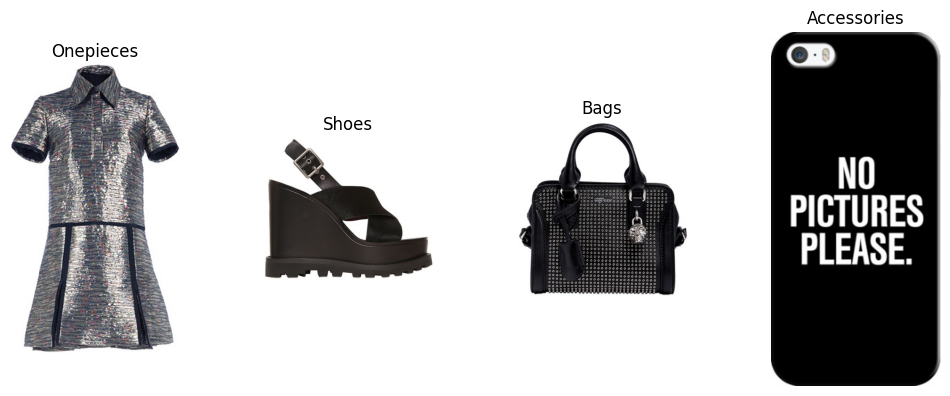

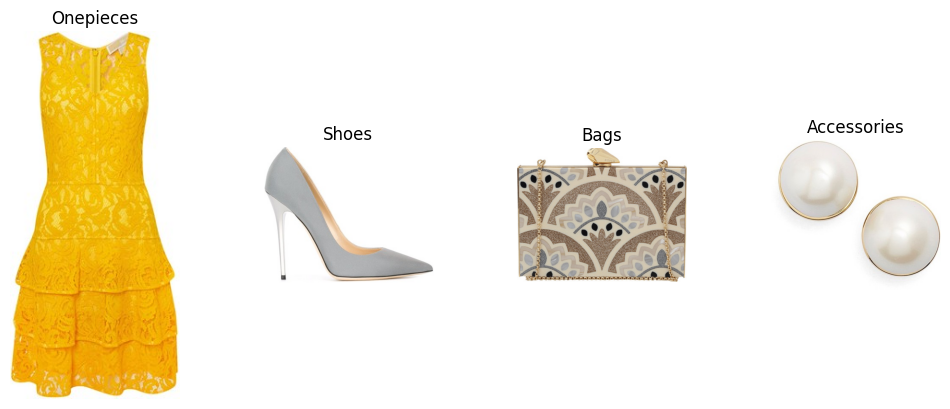

In [99]:
for i in range(0,2):
    display_outfit(i,df_image_paths_NO_Outerwear_Onepiece,4)

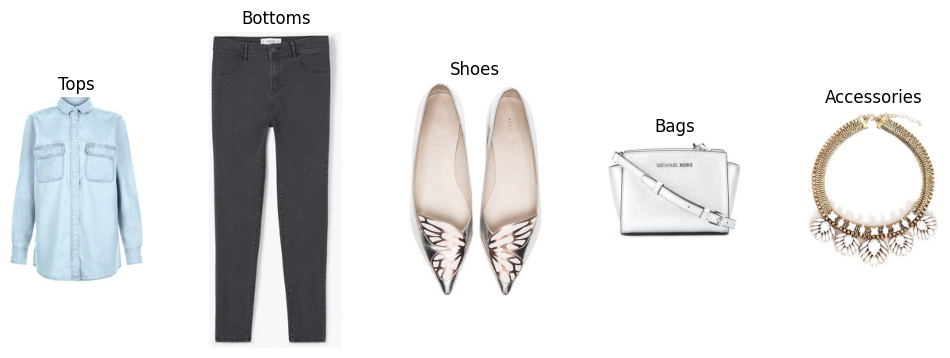

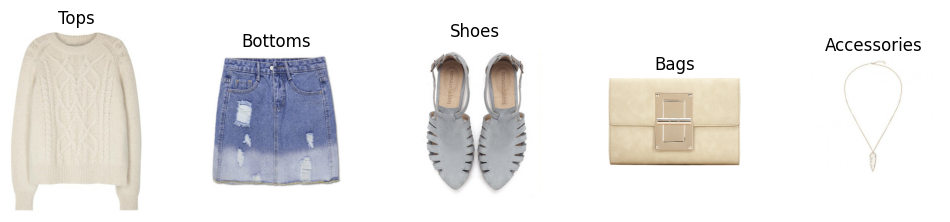

In [105]:
for i in range(0,2):
    display_outfit(i,df_image_paths_NO_Outerwear_NO_Onepiece,5)

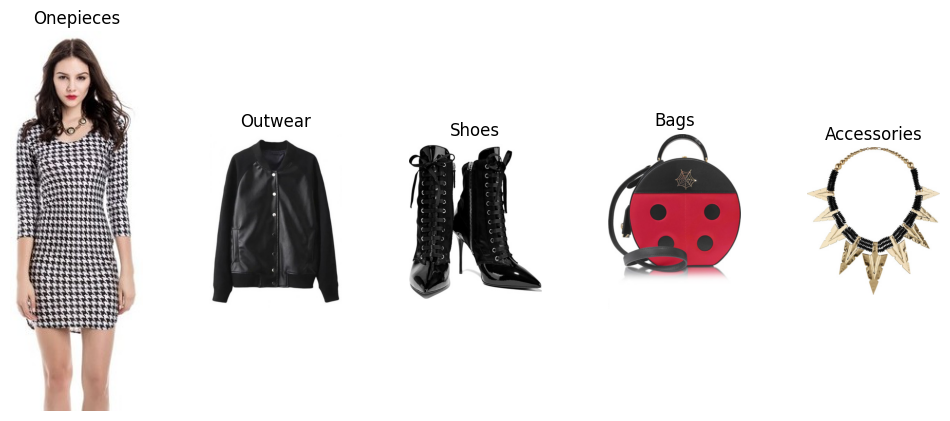

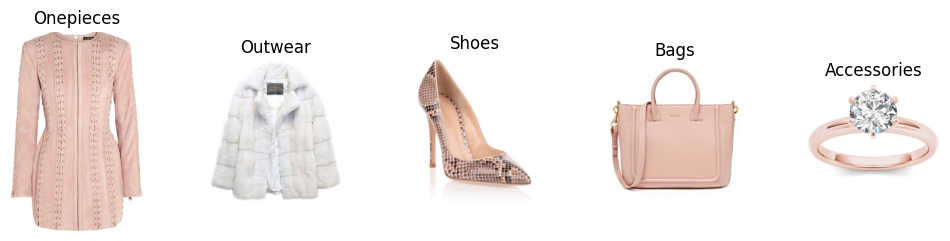

In [104]:
for i in range(0,2):
    display_outfit(i,df_image_paths_Outerwear_Onepiece,5)

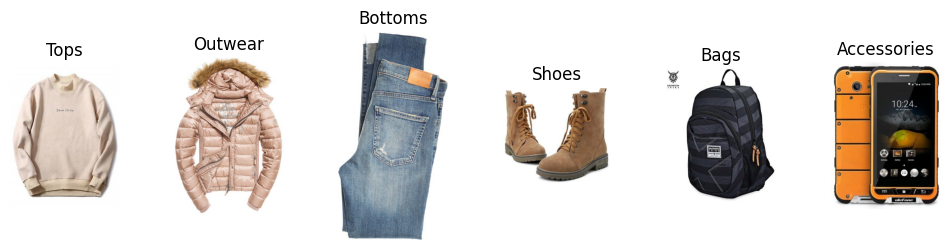

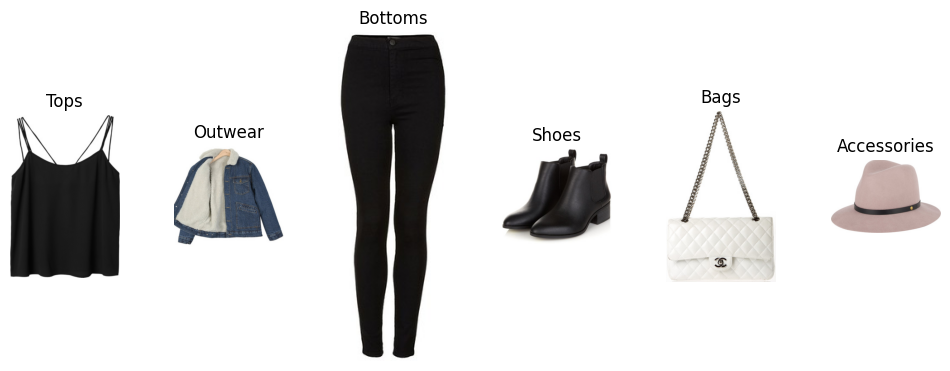

In [103]:
for i in range(0,2):
    display_outfit(i,df_image_paths_Outerwear_NO_Onepiece,6)

In [117]:
df_image_paths_NO_Outerwear_Onepiece.to_json ("image_paths_Outfits_NO_Outerwear_Onepiece.json", orient='records')
df_image_paths_NO_Outerwear_NO_Onepiece.to_json ("image_paths_Outfits_No_Outerwear_Tops_Bottoms.json", orient='records')
df_image_paths_Outerwear_Onepiece.to_json ("image_paths_Outfits_Outerwear_Onepiece.json", orient='records')
df_image_paths_Outerwear_NO_Onepiece.to_json ("image_paths_Outfits_Outerwear_Tops_Bottoms.json", orient='records')

In [118]:
with open('/home/thanos/Desktop/Sustainable_fashion/repos/Recommendation_tool/image_paths_Outfits_NO_Outerwear_Onepiece.json') as f:
    data1 = json.load(f)
image_paths_Outerwear_NO_Onepiece = pd.DataFrame(data1)

In [119]:
type(image_paths_Outerwear_NO_Onepiece)

pandas.core.frame.DataFrame